In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/UK Used Car Data set/X_train.csv")

In [3]:
df.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2
1,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0
2,12342,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9
3,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0
4,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0


In [4]:
df.isna().mean()

carID           0.0
brand           0.0
model           0.0
year            0.0
transmission    0.0
mileage         0.0
fuelType        0.0
tax             0.0
mpg             0.0
engineSize      0.0
dtype: float64

In [5]:
df.drop(["carID", "model"], axis=1, inplace=True)

In [6]:
cat_labels = [label for label, content in df.items() if pd.api.types.is_object_dtype(content)]

In [7]:
cat_labels

['brand', 'transmission', 'fuelType']

In [8]:
cat_transformer = make_pipeline(
    (OneHotEncoder(handle_unknown="ignore"))
)

In [9]:
preprocessor = make_column_transformer(
    (cat_transformer, cat_labels), remainder="passthrough"
)

In [10]:
model = make_pipeline(
    (preprocessor), (CatBoostRegressor(verbose=False))
)

In [11]:
y = pd.read_csv("data/UK Used Car Data set/y_train.csv", usecols=["price"])

In [12]:
model.fit(df, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['brand', 'transmission',
                                                   'fuelType'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x0000012B952D1BB0>)])

In [13]:
model.score(df, y)

0.9799958445275454

In [14]:
y_preds = model.predict(df)

In [15]:
mean_squared_log_error(y, y_preds, squared=False)

0.11265749934022232

Try OneHotEncoder, make_pipeline, make_column_transformer and SimpleImputer with other data

In [43]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
sns.set_palette(sns.color_palette("pastel"))

In [27]:
df = pd.read_csv("data/titanic.csv")

In [28]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [29]:
df.isna().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

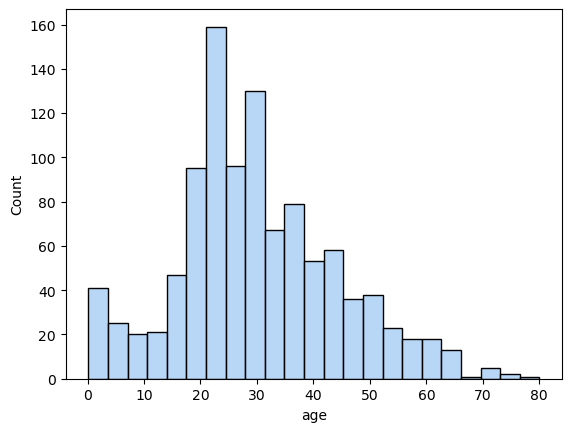

In [30]:
sns.histplot(data=df, x="age");

In [36]:
impute = SimpleImputer(strategy="constant", fill_value="missing")

def cabin_fix(df):
    """
    Fix cabin in dataframe so it has less unique values
    """
    cabin = impute.fit_transform(df[["cabin"]])
    cabin_replaced = [x[0][0] for x in cabin]
    cabin = [x if x != "m" else pd.NA for x in cabin_replaced]
    df["cabin"] = cabin
    
    return df

In [32]:
df = cabin_fix(df)

In [35]:
df.isna().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [37]:
X = df.drop(["home.dest", "name", "fare", "survived"], axis=1)
y = df["survived"]

In [41]:
cat_features = [c for c in X.columns if not pd.api.types.is_numeric_dtype(df[c])]
num_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(df[c])]

In [44]:
num_imputer = make_pipeline(
    (SimpleImputer(strategy="median")),
    (StandardScaler())
)

In [45]:
cat_imputer = make_pipeline(
    (SimpleImputer(strategy="constant", fill_value="missing")),
    (OneHotEncoder(handle_unknown="ignore"))
)

In [46]:
preprocessor = make_column_transformer(
    (num_imputer, num_features),
    (cat_imputer, cat_features),
    remainder="passthrough"
)

In [47]:
model = make_pipeline(
    (preprocessor), (CatBoostClassifier(verbose=False))
)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [51]:
model.fit(X_train, y_train)

TypeError: boolean value of NA is ambiguous